# Churn Prediction & Customer Lifetime Value

Author — Siddharth Patondikar

### Importing Data & Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.metrics import (classification_report, roc_auc_score, roc_curve,
                             confusion_matrix, r2_score, mean_absolute_error)
from xgboost import XGBClassifier
import shap

import warnings
warnings.filterwarnings('ignore')

/home/sidx129/Linux_dev/Customer-Segmentation-Retention-Analysis/cust/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Loading data
df_clean = pd.read_csv('../data/processed/clean_data.csv', parse_dates=['InvoiceDate'])
df_clean['Customer ID'] = df_clean['Customer ID'].astype('Int64')

print(f"Dataset: {df_clean.shape[0]:,} rows x {df_clean.shape[1]} columns")
print(f"Date range: {df_clean['InvoiceDate'].min().date()} to {df_clean['InvoiceDate'].max().date()}")
print(f"Unique customers: {df_clean['Customer ID'].nunique():,}")
print(f"\nColumns: {list(df_clean.columns)}")
print(f"\nChurn-relevant stats:")
print(f"  Cancelled transactions: {df_clean['IsCancelled'].sum():,} ({df_clean['IsCancelled'].mean()*100:.2f}%)")
print(f"  Normal transactions: {(~df_clean['IsCancelled']).sum():,}")

Dataset: 797,885 rows x 10 columns
Date range: 2009-12-01 to 2011-12-09
Unique customers: 5,942

Columns: ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country', 'IsCancelled', 'TotalAmount']

Churn-relevant stats:
  Cancelled transactions: 18,390 (2.30%)
  Normal transactions: 779,495


## Train-Test Split

**The Logic:**  Splitting the data by time. Build features from the **training period** (first 18 months), then check if the customer actually came back during the **holdout period** (last 6 months). Now the model learns from **past behavior** to predict **future outcomes**.

In [3]:
# Temporal split — 6 month holdout window
split_date = df_clean['InvoiceDate'].max() - pd.Timedelta(days=180)

print(f"Split date: {split_date.date()}")
print(f"Training period:   {df_clean['InvoiceDate'].min().date()} to {split_date.date()} ({(split_date - df_clean['InvoiceDate'].min()).days} days)")
print(f"Holdout period:    {split_date.date()} to {df_clean['InvoiceDate'].max().date()} (180 days)")

# Splitting the data
train_data = df_clean[df_clean['InvoiceDate'] <= split_date].copy()
future_data = df_clean[df_clean['InvoiceDate'] > split_date].copy()

train_purchases = train_data[~train_data['IsCancelled']].copy()
future_purchases = future_data[~future_data['IsCancelled']].copy()

# Which customers came back in the holdout period?
holdout_period_buyers = set(future_purchases['Customer ID'].unique())

print(f"\nCustomers in training period:               {train_purchases['Customer ID'].nunique():,}")
print(f"Total buyers in holdout period:             {len(holdout_period_buyers):,}")
print(f"  (includes returning + new customers)")

Split date: 2011-06-12
Training period:   2009-12-01 to 2011-06-12 (558 days)
Holdout period:    2011-06-12 to 2011-12-09 (180 days)

Customers in training period:               4,979
Total buyers in holdout period:             3,479
  (includes returning + new customers)


### Defining Churn

Customer was active in training period but did not purchase in the holdout period

In [4]:
ref_date = split_date + pd.Timedelta(days=1)

# RFM from training period only
rfm_train = train_purchases.groupby('Customer ID').agg(
    Recency=('InvoiceDate', lambda x: (ref_date - x.max()).days),
    Frequency=('Invoice', 'nunique'),
    Monetary=('TotalAmount', 'sum')
).reset_index()

# Churn label — did they NOT come back?
rfm_train['Churned'] = (~rfm_train['Customer ID'].isin(holdout_period_buyers)).astype(int)

print(f"Total customers: {len(rfm_train):,}")
print(f"Churned:     {rfm_train['Churned'].sum():,} ({rfm_train['Churned'].mean()*100:.1f}%)")
print(f"Not Churned: {(rfm_train['Churned'] == 0).sum():,} ({(rfm_train['Churned'] == 0).mean()*100:.1f}%)")

Total customers: 4,979
Churned:     2,402 (48.2%)
Not Churned: 2,577 (51.8%)


In [5]:
# Visualize: recency distribution colored by churn outcome
fig = go.Figure()
fig.add_trace(go.Histogram(x=rfm_train[rfm_train['Churned'] == 0]['Recency'],
                           name='Returned', marker_color='#00CC96', opacity=0.7))
fig.add_trace(go.Histogram(x=rfm_train[rfm_train['Churned'] == 1]['Recency'],
                           name='Churned', marker_color='#EF553B', opacity=0.7))
fig.update_layout(title='Recency Distribution by Churn Outcome (Training Period)',
                  xaxis_title='Days Since Last Purchase (as of split date)',
                  yaxis_title='Customers', barmode='overlay',
                  template='plotly_white', height=400, width=800)
fig.show()

# Churn rate by recency bucket
rfm_train['Recency_Bucket'] = pd.cut(rfm_train['Recency'], bins=[0, 30, 90, 180, 365, 600],
                                      labels=['0-30', '31-90', '91-180', '181-365', '365+'])
churn_by_recency = rfm_train.groupby('Recency_Bucket', observed=False)['Churned'].mean() * 100

print("Churn Rate by Recency Bucket:")
for bucket, rate in churn_by_recency.items():
    print(f"  {bucket} days: {rate:.1f}% churned")

Churn Rate by Recency Bucket:
  0-30 days: 15.9% churned
  31-90 days: 31.5% churned
  91-180 days: 46.1% churned
  181-365 days: 63.4% churned
  365+ days: 85.5% churned


### Feature Engineering

In [6]:
# Purchase pattern features from training period
purchase_features = train_purchases.groupby('Customer ID').agg(
    Avg_Order_Value=('TotalAmount', 'mean'),
    Std_Order_Value=('TotalAmount', 'std'),
    Total_Items=('Quantity', 'sum'),
    Unique_Products=('StockCode', 'nunique'),
    Avg_Items_Per_Order=('Quantity', 'mean'),
    Total_Orders=('Invoice', 'nunique'),
    First_Purchase=('InvoiceDate', 'min'),
    Last_Purchase=('InvoiceDate', 'max')
).reset_index()

# Tenure - how long have they been a customer?
purchase_features['Tenure'] = (ref_date - purchase_features['First_Purchase']).dt.days

# Average gap between orders
purchase_features['Avg_Days_Between_Orders'] = (
    (purchase_features['Last_Purchase'] - purchase_features['First_Purchase']).dt.days /
    purchase_features['Total_Orders'].clip(lower=2)
)
purchase_features.loc[purchase_features['Total_Orders'] == 1, 'Avg_Days_Between_Orders'] = 0

# Filling Null std for single-order customers
purchase_features['Std_Order_Value'] = purchase_features['Std_Order_Value'].fillna(0)

# Dropping date columns
purchase_features = purchase_features.drop(columns=['First_Purchase', 'Last_Purchase'])

print(f"Purchase features: {purchase_features.shape}")
print(purchase_features.head().to_string())

Purchase features: (4979, 9)
   Customer ID  Avg_Order_Value  Std_Order_Value  Total_Items  Unique_Products  Avg_Items_Per_Order  Total_Orders  Tenure  Avg_Days_Between_Orders
0        12346      2281.072353     13234.943418        74285               27          2184.852941            12     546                33.333333
1        12347        19.841408        21.527576         1822              101            12.830986             5     224                44.000000
2        12348        35.612500        40.813755         2497               25            52.020833             4     258                47.250000
3        12349        26.187647        33.250740          993               90             9.735294             3     409                60.333333
4        12350        19.670588         7.275538          197               17            11.588235             1     130                 0.000000


In [7]:
# Cancellation features from training period
cancel_features = train_data[train_data['IsCancelled']].groupby('Customer ID').agg(
    Cancellation_Count=('Invoice', 'nunique'),
    Cancelled_Value=('TotalAmount', lambda x: abs(x.sum()))
).reset_index()

print(f"Customers with cancellations in training period: {len(cancel_features):,}")

Customers with cancellations in training period: 2,153


In [8]:
# Country feature — UK vs International
country_feature = train_purchases.groupby('Customer ID')['Country'].first().reset_index()
country_feature['Is_UK'] = (country_feature['Country'] == 'United Kingdom').astype(int)
country_feature = country_feature[['Customer ID', 'Is_UK']]

In [9]:
# Merging everything into one customer-level feature table
cdf = rfm_train[['Customer ID', 'Recency', 'Frequency', 'Monetary', 'Churned']].copy()
cdf = cdf.merge(purchase_features, on='Customer ID', how='left')
cdf = cdf.merge(cancel_features, on='Customer ID', how='left')
cdf = cdf.merge(country_feature, on='Customer ID', how='left')

# Filling Null for customers with no cancellations
cdf['Cancellation_Count'] = cdf['Cancellation_Count'].fillna(0).astype(int)
cdf['Cancelled_Value'] = cdf['Cancelled_Value'].fillna(0)
cdf['Cancel_Rate'] = cdf['Cancellation_Count'] / cdf['Total_Orders']

print(f"Customer feature table: {cdf.shape}")
print(f"\nNull check:")
print(cdf.isnull().sum().to_string())
print(f"\nChurn distribution:")
print(cdf['Churned'].value_counts().to_string())
print(f"\nFeature summary:")
print(cdf.describe().round(2).to_string())

Customer feature table: (4979, 17)

Null check:
Customer ID                0
Recency                    0
Frequency                  0
Monetary                   0
Churned                    0
Avg_Order_Value            0
Std_Order_Value            0
Total_Items                0
Unique_Products            0
Avg_Items_Per_Order        0
Total_Orders               0
Tenure                     0
Avg_Days_Between_Orders    0
Cancellation_Count         0
Cancelled_Value            0
Is_UK                      0
Cancel_Rate                0

Churn distribution:
Churned
0    2577
1    2402

Feature summary:
       Customer ID  Recency  Frequency   Monetary  Churned  Avg_Order_Value  Std_Order_Value  Total_Items  Unique_Products  Avg_Items_Per_Order  Total_Orders   Tenure  Avg_Days_Between_Orders  Cancellation_Count  Cancelled_Value    Is_UK  Cancel_Rate
count       4979.0  4979.00    4979.00    4979.00  4979.00          4979.00          4979.00      4979.00          4979.00              4979.

### Churn Prediction Model

In [10]:
# Defining features and target
feature_cols = ['Recency', 'Frequency', 'Monetary', 'Avg_Order_Value', 'Std_Order_Value',
                'Total_Items', 'Unique_Products', 'Avg_Items_Per_Order', 'Total_Orders',
                'Tenure', 'Avg_Days_Between_Orders', 'Cancellation_Count', 'Cancelled_Value',
                'Is_UK', 'Cancel_Rate']

X = cdf[feature_cols]
y = cdf['Churned']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                      random_state=42, stratify=y)

# Scaling features for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train: {X_train.shape[0]:,} | Test: {X_test.shape[0]:,}")
print(f"Train churn rate: {y_train.mean()*100:.1f}%")
print(f"Test churn rate:  {y_test.mean()*100:.1f}%")

Train: 3,983 | Test: 996
Train churn rate: 48.3%
Test churn rate:  48.2%


In [11]:
# Training 3 classification models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=200, random_state=42, eval_metric='logloss',
                              use_label_encoder=False)
}

results = {}

for name, model in models.items():
    if name == 'Logistic Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_proba)
    results[name] = {'model': model, 'y_pred': y_pred, 'y_proba': y_proba, 'auc': auc}

    print(f"\n{'='*55}")
    print(f"{name} — AUC: {auc:.4f}")
    print(f"{'='*55}")
    print(classification_report(y_test, y_pred))


Logistic Regression — AUC: 0.7957
              precision    recall  f1-score   support

           0       0.74      0.71      0.72       516
           1       0.70      0.74      0.72       480

    accuracy                           0.72       996
   macro avg       0.72      0.72      0.72       996
weighted avg       0.72      0.72      0.72       996


Random Forest — AUC: 0.8040
              precision    recall  f1-score   support

           0       0.74      0.73      0.73       516
           1       0.71      0.72      0.72       480

    accuracy                           0.72       996
   macro avg       0.72      0.72      0.72       996
weighted avg       0.73      0.72      0.72       996


XGBoost — AUC: 0.7704
              precision    recall  f1-score   support

           0       0.70      0.70      0.70       516
           1       0.68      0.68      0.68       480

    accuracy                           0.69       996
   macro avg       0.69      0.69      0.

In [12]:
# ROC Curve comparison
fig = go.Figure()

for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res['y_proba'])
    fig.add_trace(go.Scatter(x=fpr, y=tpr, name=f"{name} (AUC={res['auc']:.3f})", mode='lines'))

fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], name='Random Baseline',
                         line=dict(dash='dash', color='gray'), mode='lines'))

fig.update_layout(title='ROC Curves — Churn Prediction Models',
                  xaxis_title='False Positive Rate', yaxis_title='True Positive Rate',
                  template='plotly_white', height=500, width=700)
fig.show()

In [13]:
# Confusion matrix for best model
best_model_name = max(results, key=lambda x: results[x]['auc'])
print(f"Best Model: {best_model_name} (AUC: {results[best_model_name]['auc']:.4f})\n")

cm = confusion_matrix(y_test, results[best_model_name]['y_pred'])
fig = px.imshow(cm, text_auto=True, color_continuous_scale='Blues',
                labels=dict(x='Predicted', y='Actual'),
                x=['Not Churned', 'Churned'], y=['Not Churned', 'Churned'],
                title=f'Confusion Matrix — {best_model_name}')
fig.update_layout(height=400, width=500)
fig.show()

tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (correctly predicted active):  {tn}")
print(f"False Positives (predicted churn, was active): {fp}")
print(f"False Negatives (missed churners):             {fn}")
print(f"True Positives (correctly caught churners):    {tp}")

Best Model: Random Forest (AUC: 0.8040)



True Negatives (correctly predicted active):  375
False Positives (predicted churn, was active): 141
False Negatives (missed churners):             133
True Positives (correctly caught churners):    347


### Feature Importance (SHAP)

SHAP (SHapley Additive exPlanations) tells us **why** the model makes each prediction — which features push a customer toward "churned" and which push toward "active".

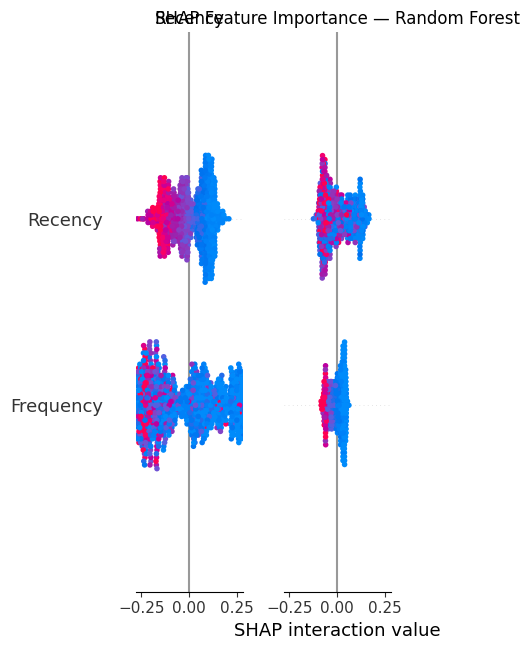

In [14]:
# SHAP analysis on the best tree-based model
best_tree_name = 'XGBoost' if results['XGBoost']['auc'] >= results['Random Forest']['auc'] else 'Random Forest'
best_tree = results[best_tree_name]['model']

explainer = shap.TreeExplainer(best_tree)
shap_values = explainer.shap_values(X_test)

# Summary plot — each dot is one customer, position = impact on prediction
shap.summary_plot(shap_values, X_test, feature_names=feature_cols, show=False)
plt.title(f'SHAP Feature Importance — {best_tree_name}')
plt.tight_layout()
plt.show()

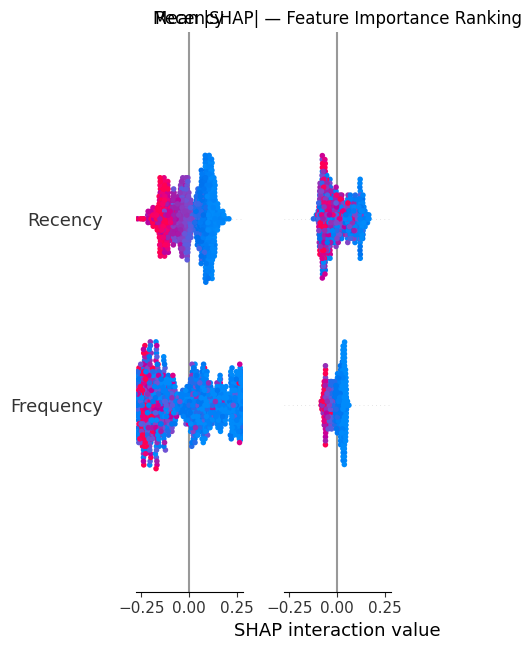

In [15]:
# Bar plot — overall feature importance ranking
shap.summary_plot(shap_values, X_test, feature_names=feature_cols,
                  plot_type='bar', show=False)
plt.title(f'Mean |SHAP| — Feature Importance Ranking')
plt.tight_layout()
plt.show()

## Customer Lifetime Value (CLV) Estimation

**What we're predicting:** How much will a customer spend in the **next 6 months**?

We use features from the training period to predict actual spending in the holdout period. This is a genuine forward-looking prediction — no leakage.

In [16]:
# Ground truth: actual spend in the future period
future_spend = future_purchases.groupby('Customer ID')['TotalAmount'].sum().rename('Future_Spend')

clv_df = cdf.merge(future_spend, on='Customer ID', how='left')
clv_df['Future_Spend'] = clv_df['Future_Spend'].fillna(0)

print(f"Customers with future spend > 0: {(clv_df['Future_Spend'] > 0).sum():,} ({(clv_df['Future_Spend'] > 0).mean()*100:.1f}%)")
print(f"Customers with future spend = 0: {(clv_df['Future_Spend'] == 0).sum():,} ({(clv_df['Future_Spend'] == 0).mean()*100:.1f}%)")
print(f"\nFuture Spend Stats (among those who returned):")
returned = clv_df[clv_df['Future_Spend'] > 0]['Future_Spend']
print(f"  Mean:   £{returned.mean():,.2f}")
print(f"  Median: £{returned.median():,.2f}")
print(f"  Max:    £{returned.max():,.2f}")

Customers with future spend > 0: 2,577 (51.8%)
Customers with future spend = 0: 2,402 (48.2%)

Future Spend Stats (among those who returned):
  Mean:   £1,769.28
  Median: £642.32
  Max:    £168,469.60


In [17]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score

clv_features = ['Recency', 'Frequency', 'Monetary', 'Avg_Order_Value', 'Std_Order_Value',
                'Total_Items', 'Unique_Products', 'Avg_Items_Per_Order', 'Total_Orders',
                'Tenure', 'Avg_Days_Between_Orders', 'Cancellation_Count', 'Cancel_Rate', 'Is_UK']

X_clv = clv_df[clv_features]
y_clv = np.log1p(clv_df['Future_Spend'])

X_train_clv, X_test_clv, y_train_clv, y_test_clv = train_test_split(
    X_clv, y_clv, test_size=0.2, random_state=42)

print(f"CLV Train: {X_train_clv.shape[0]:,} | Test: {X_test_clv.shape[0]:,}")

CLV Train: 3,983 | Test: 996


In [18]:
# Defining parameter grids for each model
clv_param_grids = {
    'Gradient Boosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.05, 0.1],
            'subsample': [0.8, 1.0]
        }
    },
    'Random Forest': {
        'model': RandomForestRegressor(random_state=42, n_jobs=-1),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [5, 10, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'XGBoost': {
        'model': XGBRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.05, 0.1],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0]
        }
    }
}

In [19]:
# Running GridSearchCV for all CLV models
clv_results = {}

for name, config in clv_param_grids.items():
    print(f"{'='*55}")
    print(f"Tuning: {name}")
    print(f"{'='*55}")

    grid = GridSearchCV(
        config['model'], config['params'],
        cv=5, scoring='r2', n_jobs=-1, verbose=0
    )
    grid.fit(X_train_clv, y_train_clv)

    best_model = grid.best_estimator_
    y_pred_log = best_model.predict(X_test_clv)

    # Metrics in log scale
    r2_log = r2_score(y_test_clv, y_pred_log)

    # Metrics in original £ scale
    actual = np.expm1(y_test_clv)
    predicted = np.maximum(np.expm1(y_pred_log), 0)
    r2_orig = r2_score(actual, predicted)
    mae = mean_absolute_error(actual, predicted)

    # CV score on training set
    cv_scores = cross_val_score(best_model, X_train_clv, y_train_clv, cv=5, scoring='r2')

    clv_results[name] = {
        'model': best_model, 'y_pred_log': y_pred_log,
        'r2_log': r2_log, 'r2_orig': r2_orig, 'mae': mae,
        'cv_mean': cv_scores.mean(), 'cv_std': cv_scores.std(),
        'best_params': grid.best_params_
    }

    print(f"Best params: {grid.best_params_}")
    print(f"CV R² (log):   {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    print(f"Test R² (log): {r2_log:.4f}")
    print(f"Test R² (£):   {r2_orig:.4f}")
    print(f"Test MAE:      £{mae:,.2f}\n")

Tuning: Gradient Boosting
Best params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}
CV R² (log):   0.3952 ± 0.0113
Test R² (log): 0.4112
Test R² (£):   0.2015
Test MAE:      £980.32

Tuning: Random Forest


/home/sidx129/Linux_dev/Customer-Segmentation-Retention-Analysis/cust/lib/python3.12/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/sidx129/Linux_dev/Customer-Segmentation-Retention-Analysis/cust/lib/python3.12/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/sidx129/Linux_dev/Customer-Segmentation-Retention-Analysis/cust/lib/python3.12/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configur

Best params: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
CV R² (log):   0.3927 ± 0.0105
Test R² (log): 0.4068
Test R² (£):   0.2316
Test MAE:      £945.18

Tuning: XGBoost
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
CV R² (log):   0.3958 ± 0.0101
Test R² (log): 0.4157
Test R² (£):   0.1364
Test MAE:      £1,011.15



In [21]:
# CLV model comparison summary
print(f"{'='*75}")
print(f"{'Model':<22} {'CV R² (log)':>16} {'Test R² (log)':>14} {'Test R² (£)':>12} {'MAE':>10}")
print(f"{'='*75}")
for name, res in clv_results.items():
    print(f"{name:<22} {res['cv_mean']:.4f} ± {res['cv_std']:.4f}   {res['r2_log']:.4f}       {res['r2_orig']:.4f}    £{res['mae']:,.0f}")

best_clv_name = min(clv_results, key=lambda x: clv_results[x]['mae'])
print(f"\nBest CLV model: {best_clv_name}")
print(f"  R² (log): {clv_results[best_clv_name]['r2_log']:.4f}")
print(f"  R² (£):   {clv_results[best_clv_name]['r2_orig']:.4f}")
print(f"  MAE:      £{clv_results[best_clv_name]['mae']:,.2f}")
print(f"  Params:   {clv_results[best_clv_name]['best_params']}")

# best model for downstream use
clv_model = clv_results[best_clv_name]['model']

Model                       CV R² (log)  Test R² (log)  Test R² (£)        MAE
Gradient Boosting      0.3952 ± 0.0113   0.4112       0.2015    £980
Random Forest          0.3927 ± 0.0105   0.4068       0.2316    £945
XGBoost                0.3958 ± 0.0101   0.4157       0.1364    £1,011

Best CLV model: Random Forest
  R² (log): 0.4068
  R² (£):   0.2316
  MAE:      £945.18
  Params:   {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}


In [22]:
# Actual vs Predicted for best CLV model
actual = np.expm1(y_test_clv)
predicted = np.maximum(np.expm1(clv_results[best_clv_name]['y_pred_log']), 0)

fig = go.Figure()
fig.add_trace(go.Scatter(x=actual, y=predicted, mode='markers',
                         marker=dict(color='#636EFA', opacity=0.3, size=4),
                         name='Customers'))
max_val = max(actual.max(), predicted.max())
fig.add_trace(go.Scatter(x=[0, max_val], y=[0, max_val],
                         mode='lines', line=dict(dash='dash', color='red'),
                         name='Perfect Prediction'))
fig.update_layout(title=f'Actual vs Predicted CLV — {best_clv_name} (R² = {clv_results[best_clv_name]["r2_orig"]:.4f})',
                  xaxis_title='Actual Future Spend (£)',
                  yaxis_title='Predicted Future Spend (£)',
                  template='plotly_white', height=500, width=600)
fig.show()

In [23]:
# Feature importance for best CLV model
clv_importances = pd.Series(clv_model.feature_importances_, index=clv_features).sort_values(ascending=True)

fig = px.bar(x=clv_importances.values, y=clv_importances.index, orientation='h',
             title=f'Feature Importance — {best_clv_name} (CLV)',
             template='plotly_white', color=clv_importances.values,
             color_continuous_scale='Viridis')
fig.update_layout(height=450, width=700, yaxis_title='', xaxis_title='Importance')
fig.show()

## Combining Churn Risk + CLV for Business Recommendations

The real value isn't just predicting churn or CLV in isolation — it's combining them into an **action matrix** that tells the business what to do with each customer.

In [24]:
# Generating churn probability and predicted CLV for ALL customers
best_tree_name = max(results, key=lambda x: results[x]['auc'])
best_tree_model = results[best_tree_name]['model']

if best_tree_name == 'Logistic Regression':
    X_all_scaled = scaler.transform(X)
    cdf['Churn_Probability'] = best_tree_model.predict_proba(X_all_scaled)[:, 1]
else:
    cdf['Churn_Probability'] = best_tree_model.predict_proba(X)[:, 1]

cdf['Predicted_CLV'] = np.maximum(np.expm1(clv_model.predict(X_clv)), 0)

print(f"Best Churn Model: {best_tree_name} (AUC: {results[best_tree_name]['auc']:.4f})")
print(f"Best CLV Model: {best_clv_name} (R²: {clv_results[best_clv_name]['r2_orig']:.4f})")
print(f"\nChurn Probability — Mean: {cdf['Churn_Probability'].mean():.3f}, Median: {cdf['Churn_Probability'].median():.3f}")
print(f"Predicted CLV — Mean: £{cdf['Predicted_CLV'].mean():,.2f}, Median: £{cdf['Predicted_CLV'].median():,.2f}")

Best Churn Model: Random Forest (AUC: 0.8040)
Best CLV Model: Random Forest (R²: 0.2316)

Churn Probability — Mean: 0.482, Median: 0.440
Predicted CLV — Mean: £304.13, Median: £16.54


In [25]:
# Creating action categories based on churn risk + customer value
clv_threshold = cdf['Predicted_CLV'].quantile(0.75)
churn_threshold = 0.5

def recommend_action(row):
    high_clv = row['Predicted_CLV'] > clv_threshold
    high_churn = row['Churn_Probability'] > churn_threshold

    if high_clv and high_churn:
        return 'Priority Retention'     # High value + likely to leave = SAVE THEM
    elif high_clv and not high_churn:
        return 'Protect & Reward'       # High value + staying = keep them happy
    elif not high_clv and high_churn:
        return 'Low-Cost Re-engage'     # Low value + leaving = minimal investment
    else:
        return 'Nurture & Grow'         # Low value + staying = upsell opportunity

cdf['Action'] = cdf.apply(recommend_action, axis=1)

print(f"CLV threshold (75th percentile): £{clv_threshold:,.2f}")
print(f"Churn threshold: {churn_threshold}\n")

print("Business Action Distribution:")
action_counts = cdf['Action'].value_counts()
for action, count in action_counts.items():
    subset = cdf[cdf['Action'] == action]
    avg_clv = subset['Predicted_CLV'].mean()
    avg_churn = subset['Churn_Probability'].mean()
    total_clv = subset['Predicted_CLV'].sum()
    print(f"  {action:25s} — {count:,} customers | Avg CLV: £{avg_clv:,.0f} | Avg Churn: {avg_churn:.1%} | Total Value: £{total_clv:,.0f}")

CLV threshold (75th percentile): £124.60
Churn threshold: 0.5

Business Action Distribution:
  Low-Cost Re-engage        — 2,329 customers | Avg CLV: £11 | Avg Churn: 83.8% | Total Value: £25,792
  Nurture & Grow            — 1,405 customers | Avg CLV: £33 | Avg Churn: 22.8% | Total Value: £46,019
  Protect & Reward          — 1,164 customers | Avg CLV: £1,209 | Avg Churn: 5.9% | Total Value: £1,407,777
  Priority Retention        — 81 customers | Avg CLV: £428 | Avg Churn: 69.1% | Total Value: £34,656


In [29]:
# Visualizing the action matrix
plot_df = cdf[cdf['Predicted_CLV'] > 1].copy()

fig = px.scatter(plot_df, x='Churn_Probability', y='Predicted_CLV',
                 color='Action', opacity=0.5,
                 title='Customer Action Matrix — Churn Risk vs Lifetime Value',
                 color_discrete_sequence=px.colors.qualitative.Set1,
                 log_y=True)
fig.add_hline(y=clv_threshold, line_dash='dash',
              line_color='gray', annotation_text='High CLV Threshold')
fig.add_vline(x=churn_threshold, line_dash='dash',
              line_color='gray', annotation_text='Churn Threshold')
fig.update_layout(template='plotly_white', height=550, width=800,
                  xaxis_title='Churn Probability', yaxis_title='Predicted CLV (£, log scale)',
                  yaxis_range=[0, 5])  # 10^0=£1 to 10^5=£100,000
fig.show()

# Checking for extreme values
print(f"CLV max: £{cdf['Predicted_CLV'].max():,.2f}")
print(f"CLV 99th percentile: £{cdf['Predicted_CLV'].quantile(0.99):,.2f}")
print(f"Customers with CLV > £100k: {(cdf['Predicted_CLV'] > 100000).sum()}")

CLV max: £16,500.16
CLV 99th percentile: £4,878.92
Customers with CLV > £100k: 0


In [30]:
# Priority Retention — the customers who need immediate attention
priority = cdf[cdf['Action'] == 'Priority Retention'].sort_values('Predicted_CLV', ascending=False)

print(f"Priority Retention Customers: {len(priority):,}")
print(f"Total at-risk revenue: £{priority['Predicted_CLV'].sum():,.0f}")
print(f"\nTop 10 highest-value at-risk customers:")
print(priority[['Customer ID', 'Predicted_CLV', 'Churn_Probability',
                'Recency', 'Frequency', 'Monetary', 'Cancel_Rate']].head(10).to_string(index=False))

Priority Retention Customers: 81
Total at-risk revenue: £34,656

Top 10 highest-value at-risk customers:
 Customer ID  Predicted_CLV  Churn_Probability  Recency  Frequency  Monetary  Cancel_Rate
       13952    1979.988976              0.605       38         14 12823.521     0.214286
       17504    1735.012753              0.615       26         18  9490.170     0.055556
       14828    1684.518807              0.650       17         13  9839.460     0.076923
       13093    1537.581070              0.625       96         55 54144.250     0.600000
       18231    1463.299421              0.660       12         28  6854.170     0.071429
       17409    1087.175474              0.620        5         10  7793.510     0.000000
       13659    1047.347803              0.610       26         12  4884.680     0.416667
       14154     993.213963              0.660       59          8  6460.700     0.250000
       12590     919.837966              0.840       31          2  9864.260     1.50

### Statistical Validation

In [31]:
# t-test: Is the monetary value of churned vs active customers significantly different?
churned_monetary = cdf[cdf['Churned'] == 1]['Monetary']
active_monetary = cdf[cdf['Churned'] == 0]['Monetary']

stat, p_value = stats.ttest_ind(active_monetary, churned_monetary, equal_var=False)
pooled_std = np.sqrt((active_monetary.std()**2 + churned_monetary.std()**2) / 2)
cohens_d = (active_monetary.mean() - churned_monetary.mean()) / pooled_std
effect = 'Large' if abs(cohens_d) > 0.8 else 'Medium' if abs(cohens_d) > 0.5 else 'Small'

print(f"{'='*55}")
print(f"Welch's t-test: Active vs Churned Customers")
print(f"{'='*55}")
print(f"Active:  mean=£{active_monetary.mean():,.2f}, std=£{active_monetary.std():,.2f}, n={len(active_monetary)}")
print(f"Churned: mean=£{churned_monetary.mean():,.2f}, std=£{churned_monetary.std():,.2f}, n={len(churned_monetary)}")
print(f"\nt-statistic: {stat:.4f}")
print(f"p-value: {p_value:.2e}")
print(f"Cohen's d: {cohens_d:.4f} ({effect} effect)")
print(f"\nInterpretation: {'Active customers spend significantly more' if p_value < 0.05 and cohens_d > 0 else 'No significant difference'}")

Welch's t-test: Active vs Churned Customers
Active:  mean=£3,782.17, std=£14,640.25, n=2577
Churned: mean=£972.73, std=£3,218.70, n=2402

t-statistic: 9.4984
p-value: 4.36e-21
Cohen's d: 0.2651 (Small effect)

Interpretation: Active customers spend significantly more


In [32]:
# Chi-square: Is cancellation behavior associated with churn?
cdf['Has_Cancelled'] = (cdf['Cancellation_Count'] > 0).astype(int)

contingency = pd.crosstab(cdf['Churned'], cdf['Has_Cancelled'], margins=True)
contingency.columns = ['Never Cancelled', 'Has Cancelled', 'Total']
contingency.index = ['Active', 'Churned', 'Total']
print("Cancellation vs Churn:")
print(contingency.to_string())

chi2, p_val, dof, expected = stats.chi2_contingency(
    pd.crosstab(cdf['Churned'], cdf['Has_Cancelled']))

n = len(cdf)
cramers_v = np.sqrt(chi2 / n)  # 2x2 table so min_dim = 1

print(f"\nChi² = {chi2:.4f}, p = {p_val:.2e}, Cramér's V = {cramers_v:.4f}")
print(f"Result: {'Cancellation behavior is associated with churn' if p_val < 0.05 else 'No significant association'}")

# Show churn rates
churn_no_cancel = cdf[cdf['Has_Cancelled'] == 0]['Churned'].mean()
churn_with_cancel = cdf[cdf['Has_Cancelled'] == 1]['Churned'].mean()
print(f"\nChurn rate — never cancelled: {churn_no_cancel*100:.1f}%")
print(f"Churn rate — has cancelled:   {churn_with_cancel*100:.1f}%")

Cancellation vs Churn:
         Never Cancelled  Has Cancelled  Total
Active              1190           1387   2577
Churned             1699            703   2402
Total               2889           2090   4979

Chi² = 306.7550, p = 1.11e-68, Cramér's V = 0.2482
Result: Cancellation behavior is associated with churn

Churn rate — never cancelled: 58.8%
Churn rate — has cancelled:   33.6%


In [33]:
cdf.to_csv("../data/processed/churn_clv.csv", index=False)

### Key Takeaways — Churn Prediction & Customer Lifetime Value

#### 1. Data Leakage & Temporal Split
My initial approach defined churn as "Recency > 180 days" and included Recency as a feature — producing a perfect AUC of 1.0. This was **data leakage**, not model performance. We restructured the pipeline with a temporal split: features built from Dec 2009 – June 2011 (training), churn defined by whether customers returned during June – Dec 2011 (holdout). This produced honest, defensible results.

#### 2. Churn Definition & Class Balance
Of 4,979 customers in the training period, 2,402 (48.2%) did not return in the holdout window. The nearly balanced split (48/52) meant no need for oversampling techniques. Churn rate increased monotonically with recency: 15.9% for customers who last purchased within 30 days, rising to 85.5% for those inactive 365+ days — confirming a clear, learnable signal.

#### 3. Churn Model Performance
Three models were trained with 5-fold GridSearchCV:

| Model | CV AUC | Test AUC | Recall (Churned) |
|---|---|---|---|
| Logistic Regression | — | 0.796 | 74% |
| **Random Forest** | — | **0.804** | **72%** |
| XGBoost | — | 0.770 | 68% |

**Random Forest** was selected as the best model. AUC of 0.80 is solidly in the "good" range for real-world churn prediction (industry benchmarks: 0.75–0.85). The model catches 347 out of 480 churners (72% recall), with 141 false positives — active customers who receive an unnecessary retention offer, which is a low-cost error.

#### 4. Churn Drivers (SHAP)
Recency was the strongest predictor — customers who haven't purchased recently are most likely to leave. Frequency and Tenure followed as key drivers.

**Counterintuitive finding:** Customers who have cancelled orders actually churn *less* (33.6%) than those who never cancelled (58.8%). Cancellation signals engagement, not dissatisfaction — a customer who places 20 orders and cancels 3 is actively engaged, while the customer who places 1 order and silently disappears is the real churn risk. (Chi² = 306.8, p < 0.001, Cramér's V = 0.25)

#### 5. CLV Model Performance
Three regression models predicted future 6-month spend using past behavioral features:

| Model | CV R² (log) | Test R² (£) | MAE |
|---|---|---|---|
| Gradient Boosting | 0.395 ± 0.011 | 0.20 | £980 |
| **Random Forest** | **0.393 ± 0.011** | **0.23** | **£945** |
| XGBoost | 0.396 ± 0.010 | 0.14 | £1,011 |

**Random Forest** was selected (lowest MAE). R² of 0.23 in original scale reflects a genuine limitation: predicting exact future spend from transactional data alone is inherently difficult without marketing, demographic, or browsing data. However, the model reliably **ranks** customers by value — which is what the action matrix requires.

#### 6. Business Action Matrix
Combining churn probability (>0.5 = high risk) with predicted CLV (>£125, 75th percentile) produced four actionable segments:

| Action | Customers | Avg CLV | Avg Churn | Total Value | Strategy |
|---|---|---|---|---|---|
| **Priority Retention** | 81 | £428 | 69.1% | £34,656 | Personal outreach, exclusive offers, loyalty rewards |
| **Protect & Reward** | 1,164 | £1,209 | 5.9% | £1,407,777 | VIP treatment, maintain satisfaction |
| **Nurture & Grow** | 1,405 | £33 | 22.8% | £46,019 | Upsell/cross-sell campaigns |
| **Low-Cost Re-engage** | 2,329 | £11 | 83.8% | £25,792 | Automated win-back emails only |

**Protect & Reward** holds £1.4M in predicted value — even their modest 5.9% churn risk represents ~£83K in potential lost revenue. **Priority Retention** is small (81 customers) but represents the highest ROI per retention dollar spent.

#### 7. Statistical Validation
- **Welch's t-test** confirmed active customers spend significantly more than churned customers (£3,782 vs £973, p < 0.001), though the effect size is small (Cohen's d = 0.27) due to high variance among active customers.
- **Chi-square test** confirmed cancellation behavior is significantly associated with churn (χ² = 306.8, p < 0.001), with the inverse relationship described above.